<a href="https://colab.research.google.com/github/bongbolobong/-/blob/main/%EB%B4%89/%EB%86%8D%EC%97%85%20%ED%99%98%EA%B2%BD%20%EB%B3%80%ED%99%94%EC%97%90%20%EB%94%B0%EB%A5%B8%20%EC%9E%91%EB%AC%BC%20%EB%B3%91%ED%95%B4%20%EC%A7%84%EB%8B%A8/resnext_%2B_lstm_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# timm
!git clone https://github.com/rwightman/pytorch-image-models
!pip install timm

!pip install "opencv-python-headless<4.3"

!pip install -U albumentations --no-binary qudida,albumentations

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score  # F1 = 2 * (precision * recall) / (precision + recall)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold  

In [4]:
!unzip -qq '/content/drive/MyDrive/data/Dacon_작물병해/data.zip'

In [5]:
!unzip -qq  "/content/test.zip"
!unzip -qq  "/content/train.zip"

In [2]:
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [3]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'

In [4]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [5]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('/content/train/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [01:02<00:00, 92.91it/s]


{'내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 온도 1 평균': [3.4, 47.3],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4],
 '내부 이슬점 평균': [0.1, 34.5]}

In [6]:
CFG={
    'img_size':512
}

In [7]:
train_transform=A.Compose([
          A.Resize(CFG['img_size'],CFG['img_size']),
          A.Transpose(p=0.5),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
          ToTensorV2(),])

In [8]:
val_transform=A.Compose([
          #A.Resize(CFG['img_size'],CFG['img_size']),
          A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
          ToTensorV2(),])

In [9]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None,transforms=False, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder
        self.transforms = transforms
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=( CFG['img_size'],  CFG['img_size']),interpolation=cv2.INTER_AREA)

        if  self.transforms != False:
          img =  self.transforms(image=img)['image']
          #img = cv2.resize(img, dsize=( CFG['img_size'],  CFG['img_size']))
        else:
          img = cv2.resize(img, dsize=( CFG['img_size'],  CFG['img_size']),interpolation=cv2.INTER_AREA)
          img = img.astype(np.float32)/255
          img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : img, #torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

In [10]:
device = torch.device("cuda:0")
batch_size = 16
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 20
vision_pretrain = True
save_path = 'best_model.pt'

In [11]:
# k-fold
# train_list = sorted(glob('/content/train/*'))
# test_list = sorted(glob('/content/test/*'))

# labelsss = pd.read_csv('/content/train.csv')['label']

# folds = []
# skf=StratifiedKFold(n_splits=4, random_state=None, shuffle=False)

# for train_index, val_index in skf.split(train_list, labelsss):
#   #print("TRAIN:", train_index, "val:", val_index)
#   folds.append((train_index,val_index))



In [12]:
#k-holding
train_list = sorted(glob('/content/train/*'))
test_list = sorted(glob('/content/test/*'))

labelsss = pd.read_csv('/content/train.csv')['label']

train, val = train_test_split(train_list, test_size=0.2, stratify=labelsss)

train_dataset = CustomDataset(train,transforms=train_transform)
val_dataset = CustomDataset(val,transforms=val_transform)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

In [13]:
'''
(avgpool): AdaptiveAvgPool2d(output_size=(1, 1)) , output shape : (C,1,1)
(fc): Linear(in_features=2048, out_features=1000, bias=True)     flatten하고 linear에 넣기 
output shape : torch.Size([1000])
'''
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        #self.model = models.resnet50(pretrained=True)
        self.model =   timm.create_model('resnext50_32x4d' ,pretrained=True)
       # self.model =   timm.create_model('efficientnet_b3' ,pretrained=True) 
    def forward(self, inputs):

        output = self.model(inputs)
        return output

In [14]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n)
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)  
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

In [15]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [16]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

In [17]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight

    def forward(self, input_, target):
        ce_loss = F.cross_entropy(input_, target,reduction=self.reduction,weight=self.weight) 
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()

In [19]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature) 
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label) 
        score = accuracy_function(label, output)
        return loss, score

In [20]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []


for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'F-1':.format(batch_acc),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'F-1':.format(batch_acc),
            'Mean F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    ## f1 mean 기준으로 model 저장    
    # val_loss_plot.append(total_val_loss/(batch+1))
    # val_metric_plot.append(total_val_acc/(batch+1))
    
    ## 단일 f1기준으로 model 저장 
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
        
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model.state_dict(), save_path)

289it [05:39,  1.18s/it, Epoch=1, Loss=0.584707, Mean Loss=0.595148, Mean F-1=0.532676]
73it [00:46,  1.57it/s, Epoch=1, Val Loss=0.000000, Mean Val Loss=0.018652, Mean Val F-1=0.782140]
289it [04:27,  1.08it/s, Epoch=2, Loss=0.348413, Mean Loss=0.126401, Mean F-1=0.694465]
73it [00:28,  2.55it/s, Epoch=2, Val Loss=0.000000, Mean Val Loss=0.008307, Mean Val F-1=0.861318]
289it [04:27,  1.08it/s, Epoch=3, Loss=0.005483, Mean Loss=0.106452, Mean F-1=0.711753]
73it [00:28,  2.56it/s, Epoch=3, Val Loss=0.000000, Mean Val Loss=0.009370, Mean Val F-1=0.868994]
289it [04:27,  1.08it/s, Epoch=4, Loss=0.003566, Mean Loss=0.079379, Mean F-1=0.746771]
73it [00:28,  2.55it/s, Epoch=4, Val Loss=0.000000, Mean Val Loss=0.005956, Mean Val F-1=0.893761]
289it [04:27,  1.08it/s, Epoch=5, Loss=0.017571, Mean Loss=0.064838, Mean F-1=0.758098]
73it [00:28,  2.57it/s, Epoch=5, Val Loss=0.000000, Mean Val Loss=0.012085, Mean Val F-1=0.863243]
289it [04:27,  1.08it/s, Epoch=6, Loss=1.241545, Mean Loss=0.0757

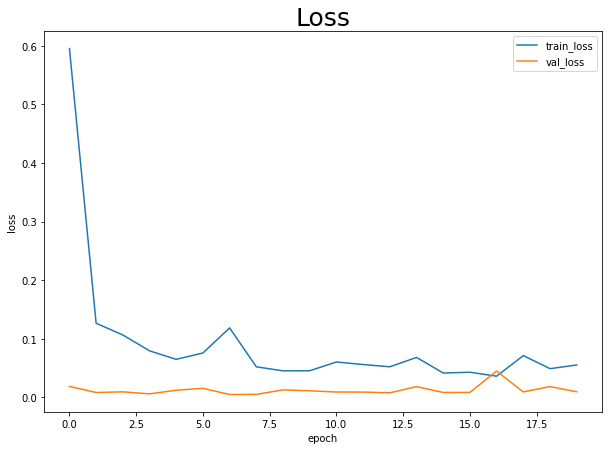

In [21]:
plt.figure(figsize=(10,7))
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

In [22]:
test_dataset = CustomDataset(test_list, mode = 'test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

In [23]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

preds = predict(test_dataloader)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
932it [09:29,  1.64it/s]


KeyboardInterrupt: ignored

In [40]:
model.load_state_dict(torch.load(save_path, map_location=device))

'best_model.pt'

In [36]:
preds = np.array([label_decoder[int(val)] for val in preds])

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['label'] = preds
submission

In [39]:
submission.to_csv('baseline_submission.csv', index=False)